Rudraksh Singh E22CSEU0010 LAB 9

Task-1:-  Image Stitching, Panorama stitching, Structure from motion, Image Inpainting

Saving 8vuLtqi.png to 8vuLtqi.png


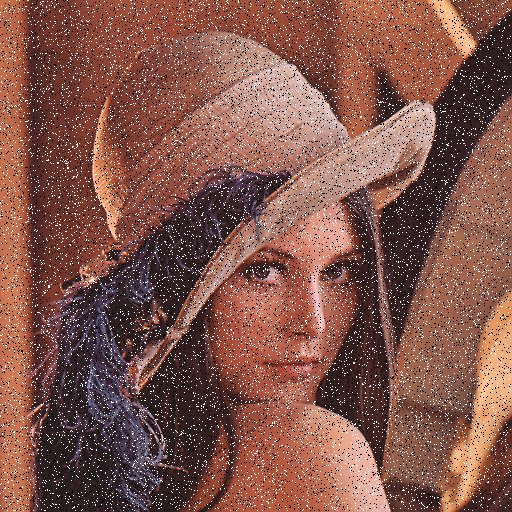

In [59]:
uploaded = files.upload()

for fn in uploaded.keys():
    img = cv2.imread(fn)

def add_salt_pepper_noise(image, amount=0.04):
    out = image.copy()
    num_salt = np.ceil(amount * image.size * 0.5).astype(int)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    out[coords[0], coords[1], :] = 255
    num_pepper = np.ceil(amount * image.size * 0.5).astype(int)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    out[coords[0], coords[1], :] = 0
    return out

noisy = add_salt_pepper_noise(img)
cv2_imshow(noisy)

Inpainted with Telea:


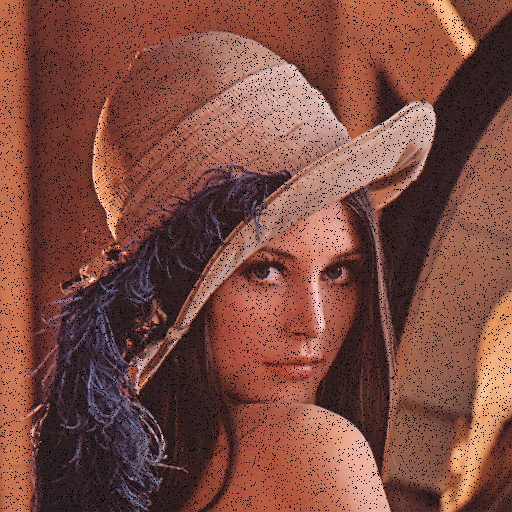

Inpainted with Navier-Stokes:


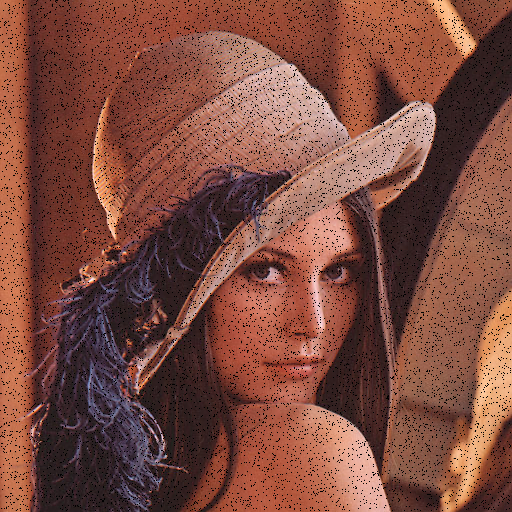

In [60]:
gray = cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)

dst_telea = cv2.inpaint(noisy, mask, 3, cv2.INPAINT_TELEA)
dst_ns = cv2.inpaint(noisy, mask, 3, cv2.INPAINT_NS)

print("Inpainted with Telea:")
cv2_imshow(dst_telea)

print("Inpainted with Navier-Stokes:")
cv2_imshow(dst_ns)

In [61]:
uploaded = files.upload()
imgs = [cv2.imread(fn) for fn in uploaded.keys()]
print(f"{len(imgs)} images loaded.")

Saving img3.jpg to img3.jpg
Saving img2.jpg to img2.jpg
Saving img1.jpg to img1.jpg
3 images loaded.


Stitching successful!


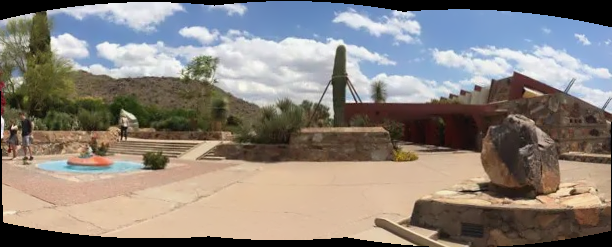

In [62]:
stitcher = cv2.Stitcher_create()
status, stitched = stitcher.stitch(imgs)

if status == cv2.Stitcher_OK:
    print("Stitching successful!")
    cv2_imshow(stitched)
else:
    print(f"Stitching failed with status code: {status}")

Saving img2.jpg to img2 (1).jpg
Saving img1.jpg to img1 (1).jpg
Manual Panorama Result:


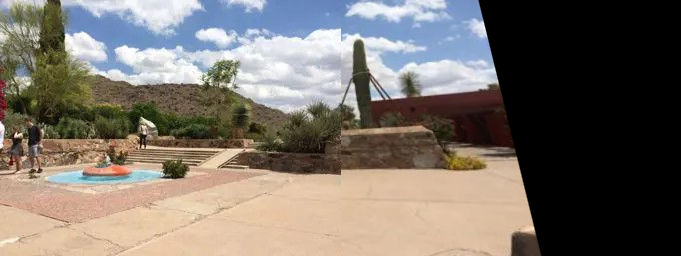

In [64]:
uploaded = files.upload()
img_names = list(uploaded.keys())
img1 = cv2.imread(img_names[0])
img2 = cv2.imread(img_names[1])
orb = cv2.ORB_create()
k1, d1 = orb.detectAndCompute(img1, None)
k2, d2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(d1, d2, k=2)
good = [m for m,n in matches if m.distance < 0.75 * n.distance]

src_pts = np.float32([k1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([k2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
width = img1.shape[1] + img2.shape[1]
height = max(img1.shape[0], img2.shape[0])
panorama = cv2.warpPerspective(img1, H, (width, height))
panorama[0:img2.shape[0], 0:img2.shape[1]] = img2

print("Manual Panorama Result:")
cv2_imshow(panorama)


In [66]:
from google.colab import files
uploaded = files.upload()

img_names = list(uploaded.keys())
img1_color = cv2.imread(img_names[0])
img2_color = cv2.imread(img_names[1])

img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

Saving graf1.png to graf1 (2).png
Saving graf3.png to graf3 (2).png


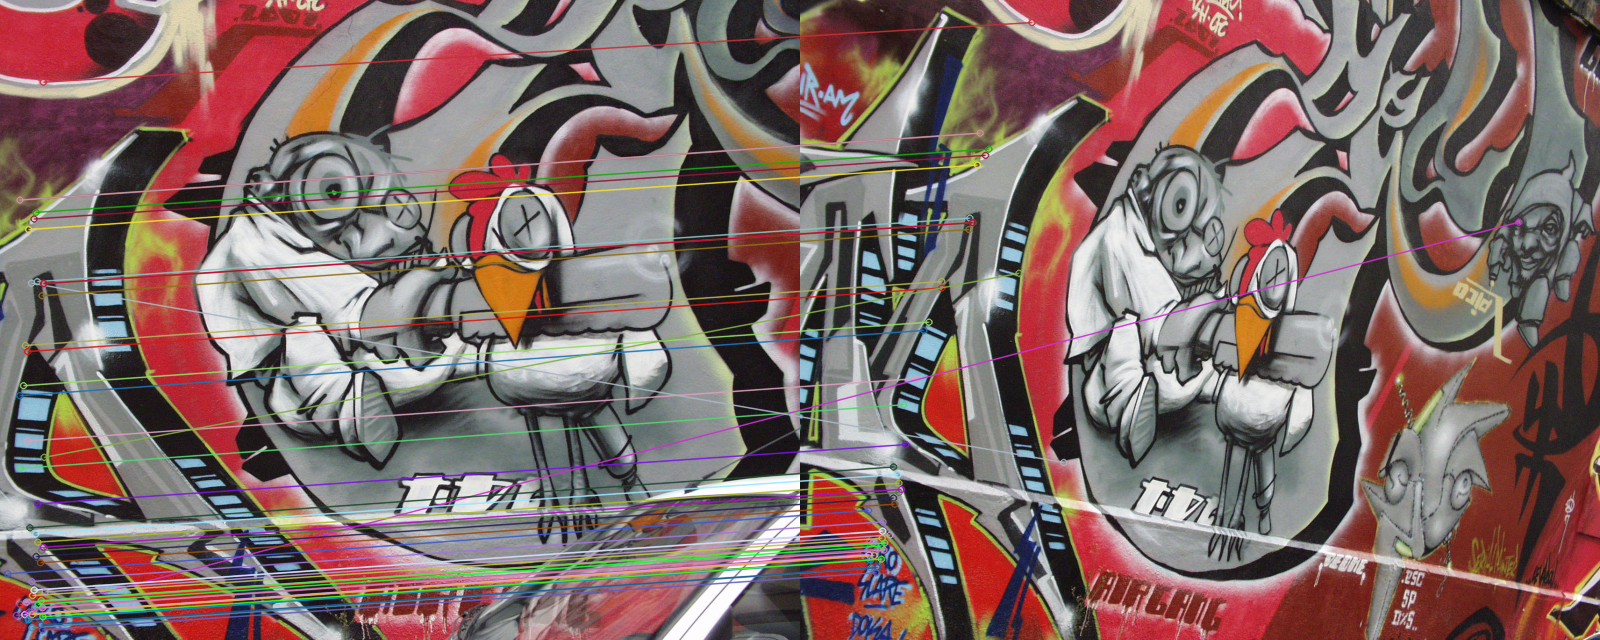

In [69]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
good = [m for m,n in matches if m.distance < 0.75 * n.distance]


img_matches = cv2.drawMatches(
    img1_color, kp1,
    img2_color, kp2,
    good[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
cv2_imshow(img_matches)


In [70]:
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

F, mask_f = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
print("Fundamental Matrix:\n", F)

# Sample intrinsics
K = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])

E, mask_e = cv2.findEssentialMat(pts1, pts2, K)
print("Essential Matrix:\n", E)

_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)
print("Recovered Rotation:\n", R)
print("Recovered Translation:\n", t)

Fundamental Matrix:
 [[-2.57786704e-06 -4.85774636e-06 -2.70711667e-03]
 [ 4.87521652e-06 -1.24280693e-06  5.00915371e-03]
 [ 1.02166688e-03 -4.95488034e-03  1.00000000e+00]]
Essential Matrix:
 [[-4.63981906e-04 -1.73947155e-01  1.71878697e-01]
 [-5.77331700e-02 -4.15121443e-02 -6.83615675e-01]
 [ 5.51901116e-02  6.81733945e-01 -2.44883166e-03]]
Recovered Rotation:
 [[ 0.89323373 -0.31720614 -0.31861227]
 [ 0.30690022  0.94807264 -0.08348968]
 [ 0.32855101 -0.02320638  0.94420109]]
Recovered Translation:
 [[0.93829621]
 [0.23500311]
 [0.25371986]]


Task-2:-  Image Restoration using Autoencoder Model


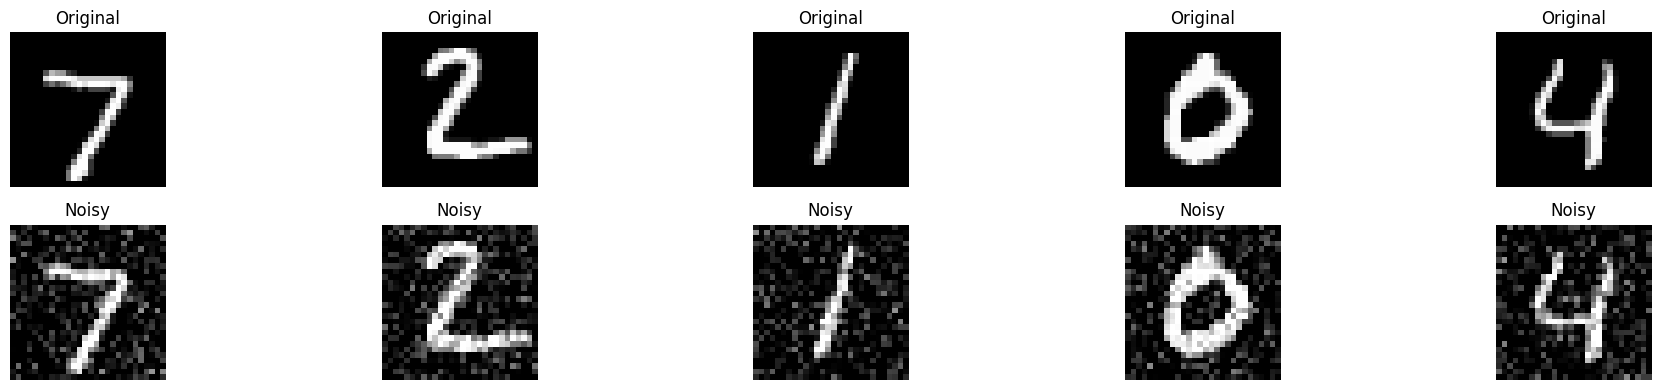

In [67]:
# noisy versions using TF operations
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# TF clip operations [0, 1]
x_train_noisy = tf.clip_by_value(x_train_noisy, 0., 1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, 0., 1.)

# examples
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    plt.subplot(2, n, i+1)
    plt.imshow(tf.squeeze(x_test[i]), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Noisy image
    plt.subplot(2, n, i+n+1)
    plt.imshow(tf.squeeze(x_test_noisy[i]), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
# autoencoder using Keras Functional API
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping],
    verbose=1
)

Step 4: Training the model...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0623 - val_loss: 0.0040
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 12/20
469/469 ━━

Step 5: Evaluating model performance...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Decoded images shape: (10000, 28, 28, 1)
Min value in decoded: 1.1745240044547245e-05, Max value: 0.9966087341308594
PSNR values for first 5 images: [np.float64(28.16778517404968), np.float64(25.32871447360605), np.float64(29.360752477234175), np.float64(23.419613190959407), np.float64(26.950157798327137)]
Average PSNR: 26.65 dB


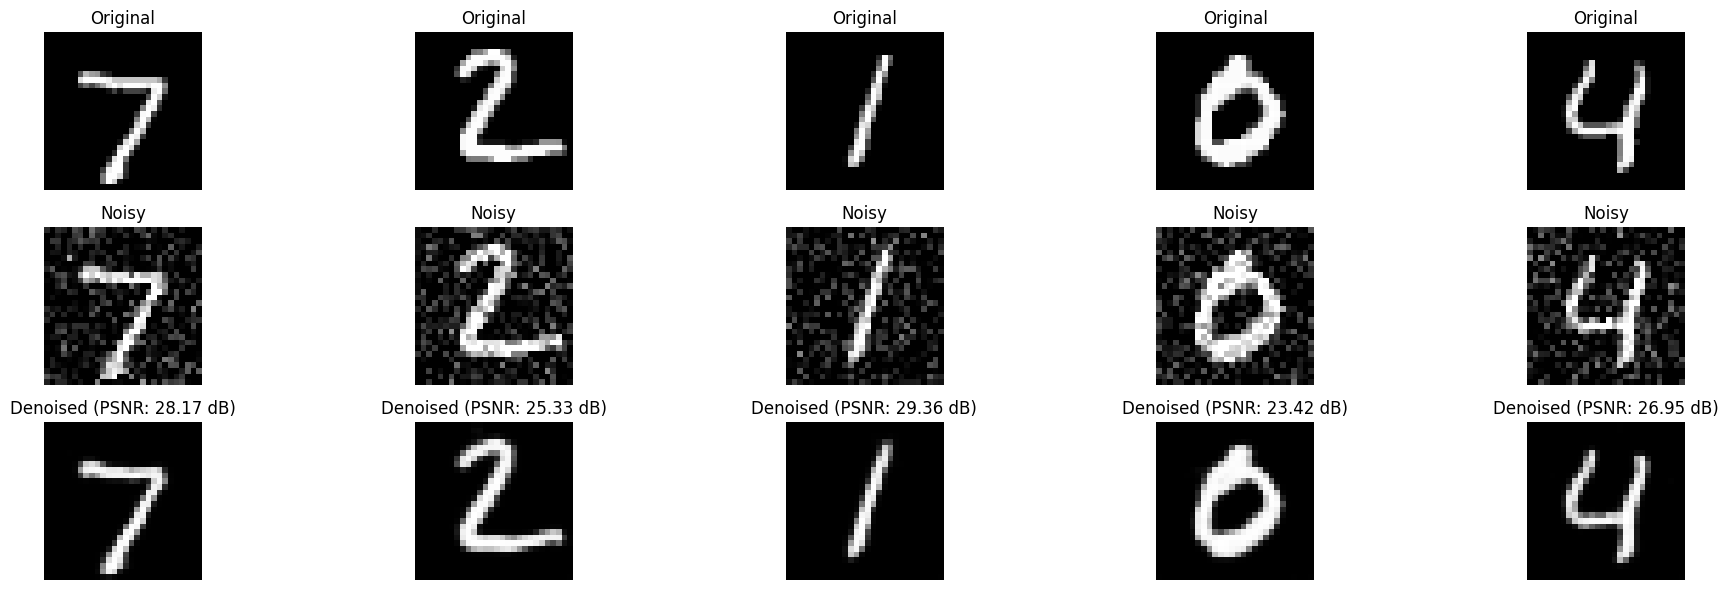

In [22]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
decoded_imgs = autoencoder.predict(x_test_noisy)

# shape and values of decoded images
print(f"Decoded images shape: {decoded_imgs.shape}")
print(f"Min value in decoded: {decoded_imgs.min()}, Max value: {decoded_imgs.max()}")

# PSNR
psnr_values = []
for i in range(n):
    psnr_value = peak_signal_noise_ratio(x_test[i], decoded_imgs[i])
    psnr_values.append(psnr_value)

print(f"PSNR values for first {n} images: {psnr_values}")
print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")

# results
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Noisy
    plt.subplot(3, n, i+n+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # Denoised
    plt.subplot(3, n, i+2*n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title(f'Denoised (PSNR: {psnr_values[i]:.2f} dB)')
    plt.axis('off')
plt.tight_layout()
plt.show()

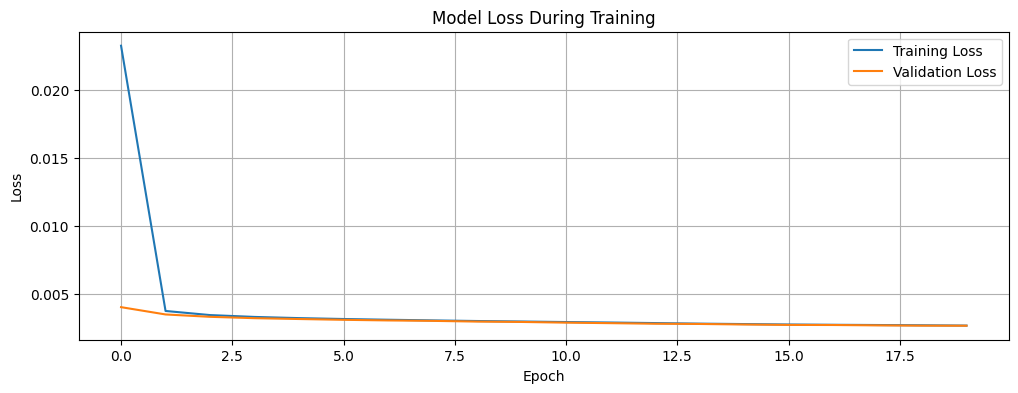

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

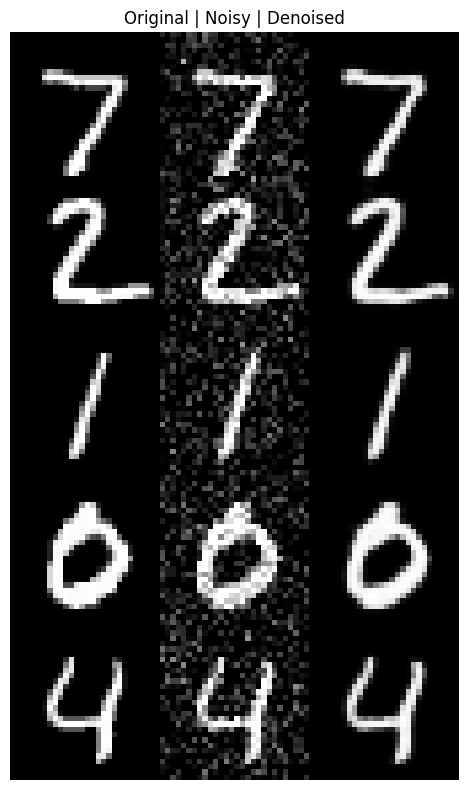

In [25]:
sample_results = np.hstack([
    x_test[:5].reshape(-1, 28),
    x_test_noisy[:5].reshape(-1, 28),
    decoded_imgs[:5].reshape(-1, 28)
])
plt.figure(figsize=(8, 8))
plt.imshow(sample_results, cmap='gray')
plt.title('Original | Noisy | Denoised')
plt.axis('off')
plt.tight_layout()
plt.savefig('denoising_results.png')
plt.show()

Generative adversarial networks on MNIST and Cifar-10 datasets

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, cifar10

# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

# Parameters
batch_size = 128
latent_dim = 100
epochs = 50

# Load and preprocess MNIST data
(mnist_images, _), (_, _) = mnist.load_data()
mnist_images = mnist_images.reshape(mnist_images.shape[0], 28, 28, 1).astype('float32')
mnist_images = (mnist_images - 127.5) / 127.5  # Normalize to [-1, 1]
mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_images).shuffle(60000).batch(batch_size)

# Load and preprocess CIFAR-10 data
(cifar_images, _), (_, _) = cifar10.load_data()
cifar_images = cifar_images.astype('float32')
cifar_images = (cifar_images - 127.5) / 127.5  # Normalize to [-1, 1]
cifar_dataset = tf.data.Dataset.from_tensor_slices(cifar_images).shuffle(50000).batch(batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [29]:
# MNIST Generator
mnist_generator = models.Sequential([
    layers.Dense(7 * 7 * 256, input_shape=(latent_dim,), use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Reshape((7, 7, 256)),

    layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
])

# MNIST Discriminator
mnist_discriminator = models.Sequential([
    layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[28, 28, 1]),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),

    layers.Conv2D(128, 5, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1)
])

# CIFAR Generator
cifar_generator = models.Sequential([
    layers.Dense(4 * 4 * 512, input_shape=(latent_dim,), use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Reshape((4, 4, 512)),

    layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(3, 5, strides=1, padding='same', use_bias=False, activation='tanh')
])

# CIFAR Discriminator
cifar_discriminator = models.Sequential([
    layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[32, 32, 3]),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),

    layers.Conv2D(128, 5, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),

    layers.Conv2D(256, 5, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Optimizers
mnist_gen_optimizer = tf.keras.optimizers.Adam(1e-4)
mnist_disc_optimizer = tf.keras.optimizers.Adam(1e-4)
cifar_gen_optimizer = tf.keras.optimizers.Adam(1e-4)
cifar_disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Seed for visualization
mnist_seed = tf.random.normal([10, latent_dim])
cifar_seed = tf.random.normal([10, latent_dim])
# Training MNIST GAN
@tf.function
def train_mnist_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = mnist_generator(noise, training=True)

        real_output = mnist_discriminator(images, training=True)
        fake_output = mnist_discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, mnist_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, mnist_discriminator.trainable_variables)

    mnist_gen_optimizer.apply_gradients(zip(gradients_of_generator, mnist_generator.trainable_variables))
    mnist_disc_optimizer.apply_gradients(zip(gradients_of_discriminator, mnist_discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training CIFAR GAN
@tf.function
def train_cifar_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = cifar_generator(noise, training=True)

        real_output = cifar_discriminator(images, training=True)
        fake_output = cifar_discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, cifar_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, cifar_discriminator.trainable_variables)

    cifar_gen_optimizer.apply_gradients(zip(gradients_of_generator, cifar_generator.trainable_variables))
    cifar_disc_optimizer.apply_gradients(zip(gradients_of_discriminator, cifar_discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
mnist_gen_losses = []
mnist_disc_losses = []
cifar_gen_losses = []
cifar_disc_losses = []

In [31]:
print("Training GAN on MNIST dataset...")
for epoch in range(epochs):
    mnist_g_loss_epoch = 0
    mnist_d_loss_epoch = 0
    mnist_steps = 0

    for image_batch in mnist_dataset:
        g_loss, d_loss = train_mnist_step(image_batch)
        mnist_g_loss_epoch += g_loss
        mnist_d_loss_epoch += d_loss
        mnist_steps += 1

    mnist_gen_losses.append(mnist_g_loss_epoch/mnist_steps)
    mnist_disc_losses.append(mnist_d_loss_epoch/mnist_steps)

    if (epoch + 1) % 10 == 0:
        print(f"MNIST Epoch {epoch+1}/{epochs}, Gen Loss: {mnist_gen_losses[-1]}, Disc Loss: {mnist_disc_losses[-1]}")

Training GAN on MNIST dataset...
MNIST Epoch 10/50, Gen Loss: 1.1741819381713867, Disc Loss: 1.0736947059631348
MNIST Epoch 20/50, Gen Loss: 0.9447759389877319, Disc Loss: 1.2186764478683472
MNIST Epoch 30/50, Gen Loss: 0.9461756944656372, Disc Loss: 1.211600422859192
MNIST Epoch 40/50, Gen Loss: 0.9269723892211914, Disc Loss: 1.2315068244934082
MNIST Epoch 50/50, Gen Loss: 0.8896484375, Disc Loss: 1.2477340698242188


In [32]:
print("\nTraining GAN on CIFAR-10 dataset...")
for epoch in range(epochs):
    cifar_g_loss_epoch = 0
    cifar_d_loss_epoch = 0
    cifar_steps = 0

    for image_batch in cifar_dataset:
        g_loss, d_loss = train_cifar_step(image_batch)
        cifar_g_loss_epoch += g_loss
        cifar_d_loss_epoch += d_loss
        cifar_steps += 1

    cifar_gen_losses.append(cifar_g_loss_epoch/cifar_steps)
    cifar_disc_losses.append(cifar_d_loss_epoch/cifar_steps)

    if (epoch + 1) % 10 == 0:
        print(f"CIFAR Epoch {epoch+1}/{epochs}, Gen Loss: {cifar_gen_losses[-1]}, Disc Loss: {cifar_disc_losses[-1]}")


Training GAN on CIFAR-10 dataset...
CIFAR Epoch 10/50, Gen Loss: 3.042559862136841, Disc Loss: 0.48007312417030334
CIFAR Epoch 20/50, Gen Loss: 3.661092519760132, Disc Loss: 0.396057665348053
CIFAR Epoch 30/50, Gen Loss: 2.925020217895508, Disc Loss: 0.5660783052444458
CIFAR Epoch 40/50, Gen Loss: 2.8913536071777344, Disc Loss: 0.5621509552001953
CIFAR Epoch 50/50, Gen Loss: 2.7225122451782227, Disc Loss: 0.6198186874389648


In [33]:
# Generate final images
mnist_generated_images = mnist_generator(mnist_seed, training=False)
cifar_generated_images = cifar_generator(cifar_seed, training=False)

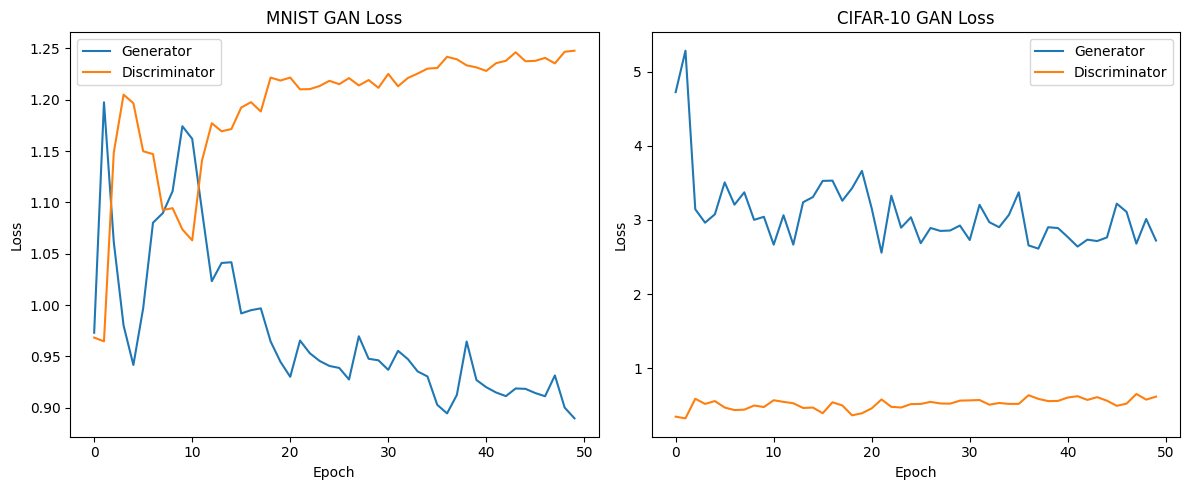

In [35]:
# Plot the losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mnist_gen_losses, label='Generator')
plt.plot(mnist_disc_losses, label='Discriminator')
plt.title('MNIST GAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cifar_gen_losses, label='Generator')
plt.plot(cifar_disc_losses, label='Discriminator')
plt.title('CIFAR-10 GAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('gan_losses.png')
plt.show()


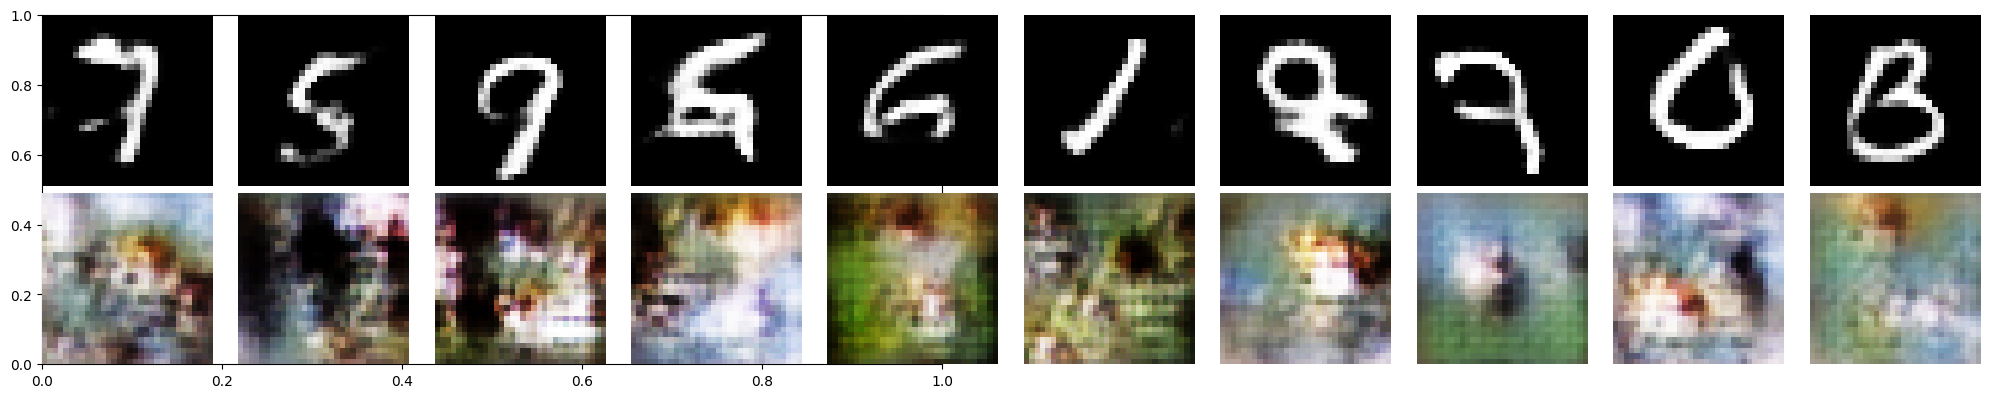

In [36]:
# Display generated images
plt.figure(figsize=(20, 4))

# MNIST images
plt.subplot(1, 2, 1)
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(mnist_generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')

# CIFAR images
for i in range(10):
    plt.subplot(2, 10, i+11)
    plt.imshow((cifar_generated_images[i] * 0.5 + 0.5).numpy())
    plt.axis('off')

plt.tight_layout()
plt.savefig('generated_images.png')
plt.show()

Unet for image segmentation

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_datasets as tfds

tf.random.set_seed(42)

# Oxford-IIIT Pet dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50
BUFFER_SIZE = 1000

# Preprocess images
def preprocess(data):
    input_image = tf.cast(data['image'], tf.float32)
    input_mask = tf.cast(data['segmentation_mask'], tf.float32)

    # Resize
    input_image = tf.image.resize(input_image, [IMG_SIZE, IMG_SIZE])
    input_mask = tf.image.resize(input_mask, [IMG_SIZE, IMG_SIZE])

    # Normalize
    input_image = input_image / 255.0

    #  mask to one-hot
    input_mask = tf.cast(input_mask > 1, tf.float32)

    return input_image, input_mask

#  datasets
train_dataset = dataset['train'].map(preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.8CO4FA_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.8CO4FA_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [51]:
def unet_model(output_channels=1):
    # Encoder
    inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Encoder path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder path
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    concat6 = layers.Concatenate()([up6, drop4])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = layers.Concatenate()([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = layers.Concatenate()([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(output_channels, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

#compile model
model = unet_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=[dice_coef, iou, 'binary_accuracy']
)

#callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]

In [52]:
# Train
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 159s 830ms/step - binary_accuracy: 0.7088 - dice_coef: 0.7465 - iou: 0.6053 - loss: 0.2535 - val_binary_accuracy: 0.7043 - val_dice_coef: 0.8262 - val_iou: 0.7043 - val_loss: 0.1739 - learning_rate: 1.0000e-04
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 578ms/step - binary_accuracy: 0.7061 - dice_coef: 0.8274 - iou: 0.7061 - loss: 0.1726 - val_binary_accuracy: 0.7043 - val_dice_coef: 0.8262 - val_iou: 0.7043 - val_loss: 0.1739 - learning_rate: 1.0000e-04
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 584ms/step - binary_accuracy: 0.7045 - dice_coef: 0.8263 - iou: 0.7045 - loss: 0.1737 - val_binary_accuracy: 0.7043 - val_dice_coef: 0.8262 - val_iou: 0.7043 - val_loss: 0.1739 - learning_rate: 1.0000e-04
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 587ms/step - binary_accuracy: 0.7083 - dice_coef: 0.8289 - iou: 0.7083 - loss: 0.1711 - val_binary_accuracy: 0.7043 - val_dice_coef: 0.8262 - val_iou: 0.7043 - val_loss: 0.1739 - learning_rate: 1.0000e-04
Epo

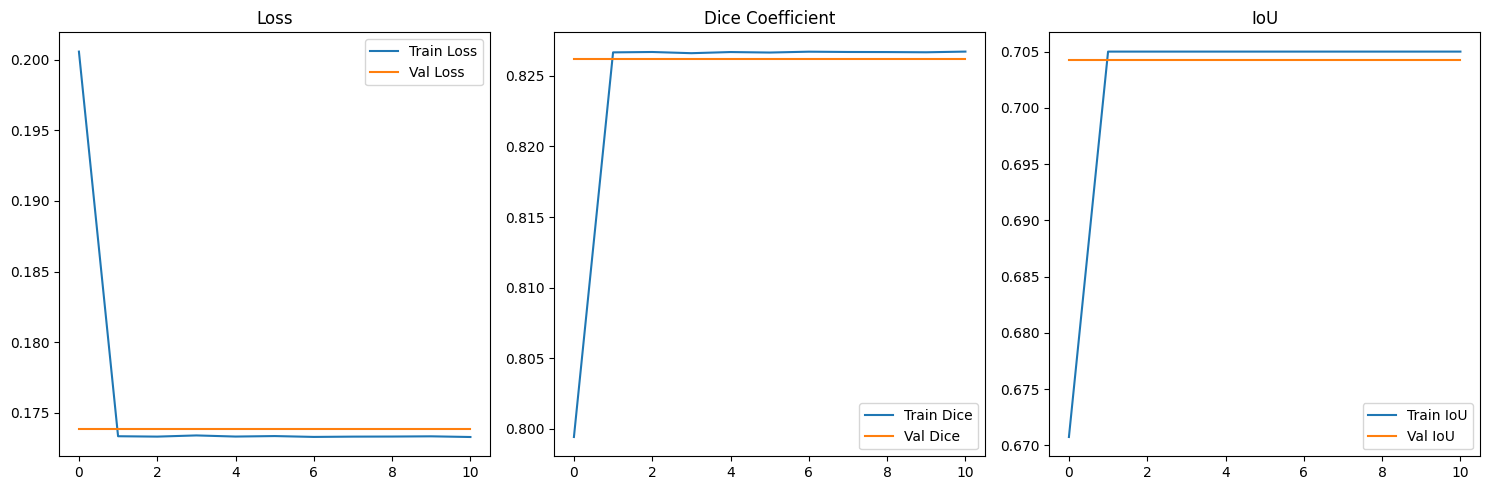

In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Val IoU')
plt.title('IoU')
plt.legend()

plt.tight_layout()
plt.savefig('unet_training_history.png')
plt.show()

In [54]:
def display_sample(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('unet_prediction_examples.png')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


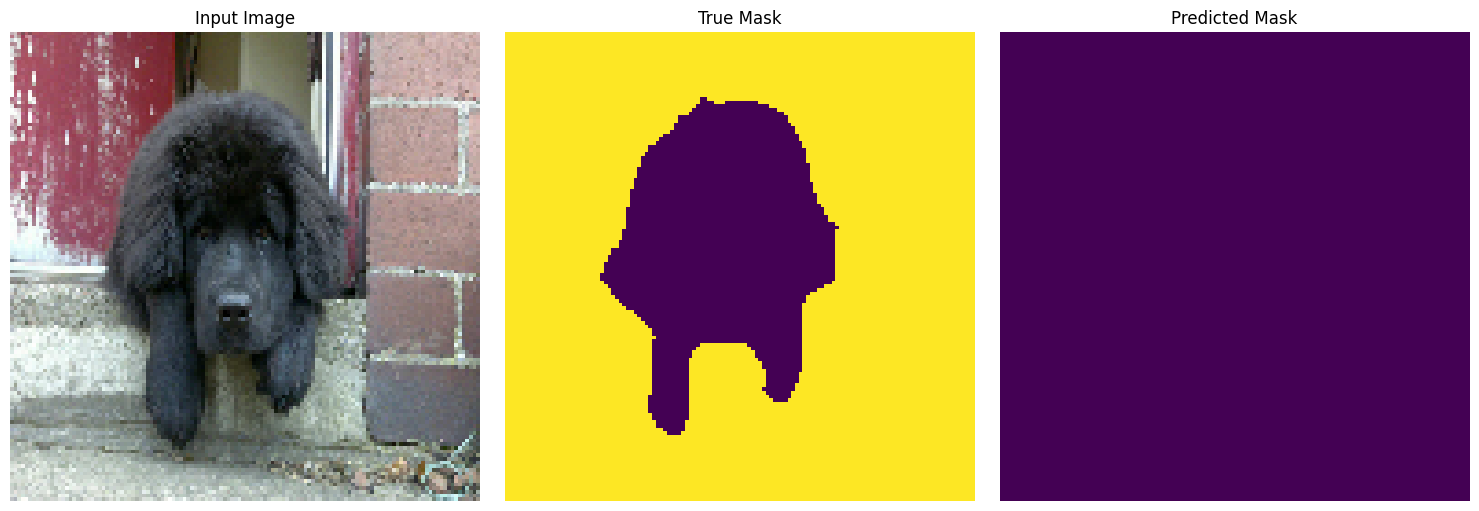

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


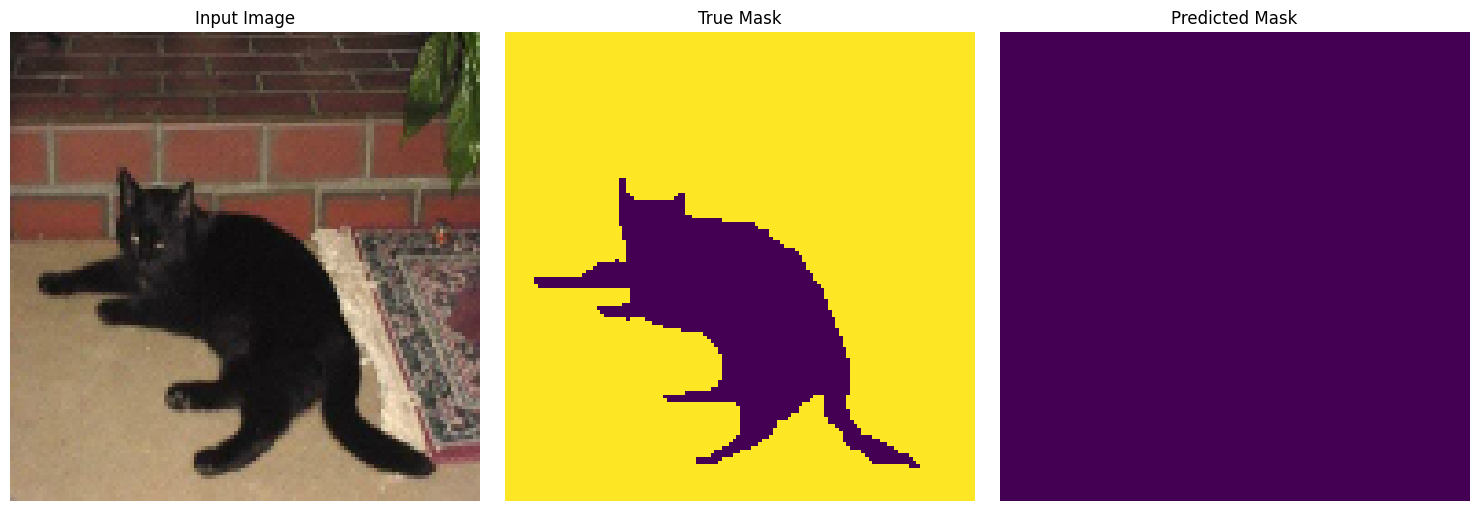

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


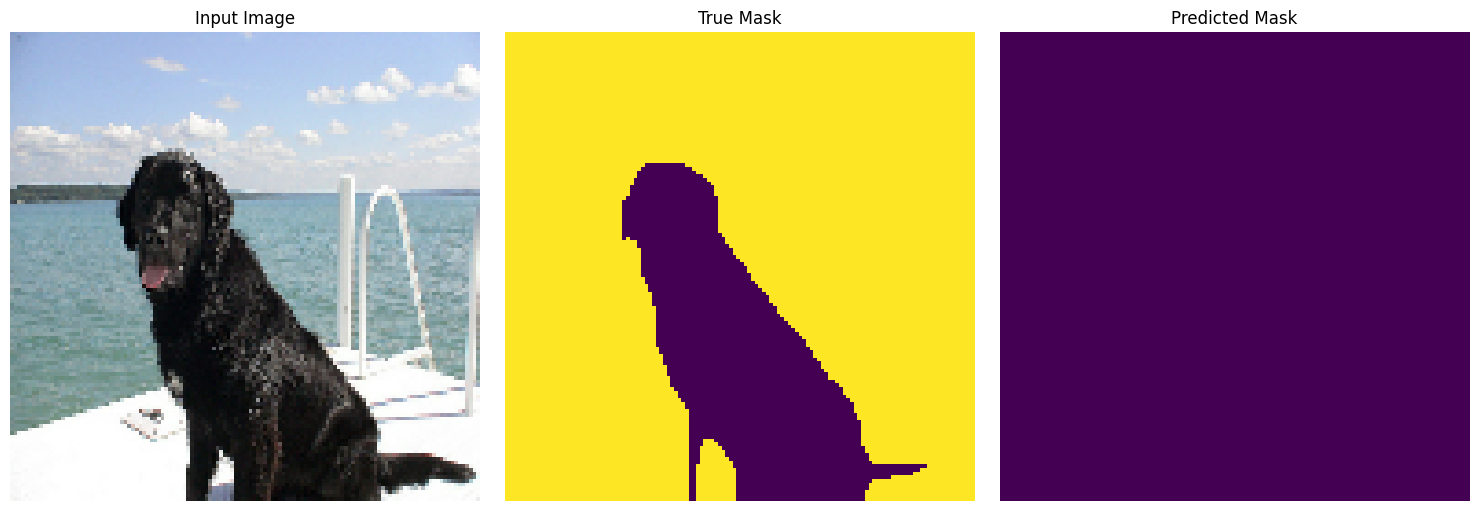

In [55]:
# predictions
for images, masks in test_dataset.take(3):
    # random image
    idx = np.random.randint(0, images.shape[0])
    sample_image = images[idx]
    sample_mask = masks[idx]

    # Making prediction
    pred_mask = model.predict(sample_image[tf.newaxis, ...])[0]

    # results
    display_sample([sample_image, sample_mask, pred_mask])

In [56]:
# Evaluate model on test set
test_results = model.evaluate(test_dataset)
print("\nTest Results:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Dice Coefficient: {test_results[1]:.4f}")
print(f"IoU: {test_results[2]:.4f}")
print(f"Accuracy: {test_results[3]:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - binary_accuracy: 0.7025 - dice_coef: 0.8250 - iou: 0.7025 - loss: 0.1750

Test Results:
Loss: 0.1739
Dice Coefficient: 0.8262
IoU: 0.7043
Accuracy: 0.7043


Mobilenet based image classification

In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gauravduttakiit/dogs-breed-dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/dogs-breed-dataset
License(s): copyright-authors


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd

tf.random.set_seed(42)
DATASET_PATH = './dogs_dataset'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = len(os.listdir(TRAIN_PATH))

In [6]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Class labels
class_names = list(train_generator.class_indices.keys())
print(f"Dog breeds: {class_names}")

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
callbacks = [early_stop, reduce_lr]

Found 662 images belonging to 5 classes.
Found 162 images belonging to 5 classes.
Found 206 images belonging to 5 classes.
Dog breeds: ['french_bulldog', 'german_shepherd', 'golden_retriever', 'poodle', 'yorkshire_terrier']


In [7]:
results = {}

for version in ['v1', 'v2', 'v3']:
    print(f"\n📦 Training MobileNet {version.upper()}...")

    #  model selection
    if version == 'v1':
        base_model = applications.MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    elif version == 'v2':
        base_model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    else:
        base_model = applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    base_model.trainable = False

    #  model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=EPOCHS,
        callbacks=callbacks
    )

    # Evaluate
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"✅ Test accuracy: {test_acc:.4f}")

    results[version] = {
        'history': history.history,
        'test_accuracy': test_acc
    }

# Plot training history
plt.figure(figsize=(12, 10))


📦 Training MobileNet V1...
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
13/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4382 - loss: 1.7750

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/21 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4671 - loss: 1.6808

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5433 - loss: 1.4384 - val_accuracy: 0.9630 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9324 - loss: 0.2229 - val_accuracy: 0.9691 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9614 - loss: 0.1464 - val_accuracy: 0.9630 - val_loss: 0.1003 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9483 - loss: 0.1321 - val_accuracy: 0.9815 - val_loss: 0.0592 - learning_rate: 0.0010
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9711 - loss: 0.0859 - val_accuracy: 0.9877 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9636 - loss: 0.1078 - val_accuracy: 0.9877 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9667 - loss: 0.1086 - val_accuracy: 0.9815 - va

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

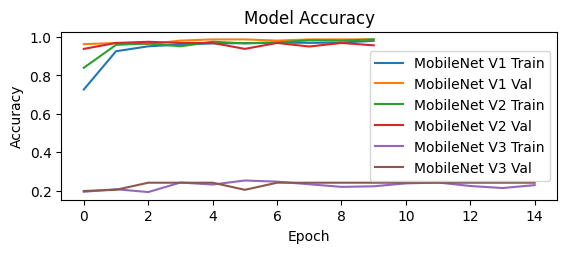

In [8]:
# Accuracy
plt.subplot(2, 1, 1)
for version in results:
    plt.plot(results[version]['history']['accuracy'], label=f'MobileNet {version.upper()} Train')
    plt.plot(results[version]['history']['val_accuracy'], label=f'MobileNet {version.upper()} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


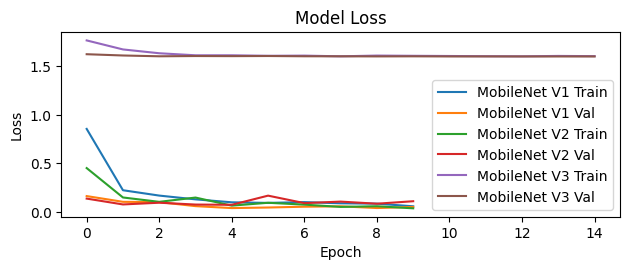

In [9]:
# Loss
plt.subplot(2, 1, 2)
for version in results:
    plt.plot(results[version]['history']['loss'], label=f'MobileNet {version.upper()} Train')
    plt.plot(results[version]['history']['val_loss'], label=f'MobileNet {version.upper()} Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
comparison = pd.DataFrame({
    'Model Version': [f'MobileNet {v.upper()}' for v in results],
    'Test Accuracy': [results[v]['test_accuracy'] for v in results],
    'Final Train Accuracy': [results[v]['history']['accuracy'][-1] for v in results],
    'Final Val Accuracy': [results[v]['history']['val_accuracy'][-1] for v in results]
})

print("\n📊 Final Model Comparison:")
print(comparison)


📊 Final Model Comparison:
  Model Version  Test Accuracy  Final Train Accuracy  Final Val Accuracy
0  MobileNet V1       0.990291              0.980363            0.987654
1  MobileNet V2       0.995146              0.987915            0.956790
2  MobileNet V3       0.233010              0.228097            0.240741
